### **This notebook involves the Sentiment analysis of Restaraunt reviews using scraped dataset.**

Install required libraries

In [ ]:
!pip install scikit-plot
!pip install pyspellchecker

Import required libraries

In [ ]:
import pandas as pd
import re
import string
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import sent_tokenize, word_tokenize, WordPunctTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.svm import SVC, LinearSVC,NuSVC, libsvm
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_confusion_matrix, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from collections import Counter
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.libsvm module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbor

Load the data

In [ ]:
df = pd.read_csv('/content/sentiment_analysis.csv')
df = df.drop('Unnamed: 0',axis=1)
df.head()

,Title,ReviewDate,Stay Date,comments,Restaurant_Name,Review_Sentiment
0,b'Highly recommended',"b'Reviewed September 14, 2020 '",b'Date of visit: September 2020',[b'We went for Lunch. From very first their pa...,The Four Leafed Clover,POSITIVE
1,"b'Excellent food, great ambience'","b'Reviewed September 5, 2020 '",b'Date of visit: September 2020',[b'Great service and delicious food. We had th...,The Four Leafed Clover,POSITIVE
2,b'Excellent Food and Place',"b'Reviewed August 15, 2020 '",b'Date of visit: August 2020',"[b'As I went, there were enough parking space,...",The Four Leafed Clover,POSITIVE
3,b'Good Food and Ambience\n\n Food',"b'Reviewed February 9, 2020 '",b'Date of visit: February 2020',[b'Good Food and Ambience\n\n Food and ambienc...,The Four Leafed Clover,POSITIVE
4,b'Loved everything about The Four Leafed Clover',"b'Reviewed January 17, 2020 '",b'Date of visit: January 2020',"[b""Excellent quiet and clean place for a relax...",The Four Leafed Clover,POSITIVE


In [ ]:
#Check columns
df.columns

Index(['Title', 'ReviewDate', 'Stay Date', 'comments', 'Restaurant_Name',
       'Review_Sentiment'],
      dtype='object')

In [ ]:
# General stats about datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             3861 non-null   object
 1   ReviewDate        3861 non-null   object
 2   Stay Date         3861 non-null   object
 3   comments          3861 non-null   object
 4   Restaurant_Name   3861 non-null   object
 5   Review_Sentiment  3861 non-null   object
dtypes: object(6)
memory usage: 181.1+ KB


In [ ]:
# Change column names for better readability
df = df.rename(columns = {'comments':'Review'})

Here, in columns, we have added **Review_Sentiment**,& **Sentiment_Score**. We have extracted Review_Sentiment & Sentiment_Score using **Transformer** library from **Huggingface**.

### **Text Pre-processing**

We will do the text pre-processing, which involves **removing stop words & special characters, convert to lowercase letters, Stemming & Lemmatzation**.

Let's consider **Review** feature for text pre-processing.

In [ ]:
# strip [b''b]
df['review_preprocessed'] = df['Review'].str.strip('[b''b]')
# Replace \n by ''
df = df.replace(r'\\n',' ', regex=True)
df[['Review','review_preprocessed']].head()

,Review,review_preprocessed
0,[b'We went for Lunch. From very first their pa...,'We went for Lunch. From very first their part...
1,[b'Great service and delicious food. We had th...,'Great service and delicious food. We had the ...
2,"[b'As I went, there were enough parking space,...","'As I went, there were enough parking space, t..."
3,[b'Good Food and Ambience Food and ambience ...,'Good Food and Ambience Food and ambience wa...
4,"[b""Excellent quiet and clean place for a relax...","""Excellent quiet and clean place for a relaxed..."


**Lower casing**

Lower casing is a common text preprocessing technique. The idea is to convert the input text into same casing format so that 'text', 'Text' and 'TEXT' are treated the same way.



In [ ]:
df["review_preprocessed"] = df["review_preprocessed"].str.strip().str.lower()
df[['Review','review_preprocessed']].head()

,Review,review_preprocessed
0,[b'We went for Lunch. From very first their pa...,'we went for lunch. from very first their part...
1,[b'Great service and delicious food. We had th...,'great service and delicious food. we had the ...
2,"[b'As I went, there were enough parking space,...","'as i went, there were enough parking space, t..."
3,[b'Good Food and Ambience Food and ambience ...,'good food and ambience food and ambience wa...
4,"[b""Excellent quiet and clean place for a relax...","""excellent quiet and clean place for a relaxed..."


**Removal of Punctuations**

Another common text preprocessing technique is to remove the punctuations from the text data. This is again a text standardization process that will help to treat 'hurray' and 'hurray!' in the same way.

In [ ]:
punct_to_remove = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', punct_to_remove))
  
df['review_preprocessed'] = df['review_preprocessed'].apply(lambda review : remove_punctuation(review))

df[['Review','review_preprocessed']].head()


,Review,review_preprocessed
0,[b'We went for Lunch. From very first their pa...,we went for lunch from very first their part o...
1,[b'Great service and delicious food. We had th...,great service and delicious food we had the la...
2,"[b'As I went, there were enough parking space,...",as i went there were enough parking space the ...
3,[b'Good Food and Ambience Food and ambience ...,good food and ambience food and ambience was...
4,"[b""Excellent quiet and clean place for a relax...",excellent quiet and clean place for a relaxed ...


**Removal of stopwords**

Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text, as they don't provide valuable information for downstream tasks.

In [ ]:
#Download stopwords from nltk libraries
nltk.download('stopwords')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["review_preprocessed"] = df["review_preprocessed"].apply(lambda text: remove_stopwords(text))
df[['Review','review_preprocessed']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,review_preprocessed
0,[b'We went for Lunch. From very first their pa...,went lunch first part welcoming customer upto ...
1,[b'Great service and delicious food. We had th...,great service delicious food lamb shank creamy...
2,"[b'As I went, there were enough parking space,...",went enough parking space staff friendly helpf...
3,[b'Good Food and Ambience Food and ambience ...,good food ambience food ambience great definit...
4,"[b""Excellent quiet and clean place for a relax...",excellent quiet clean place relaxed hangout fo...


**Lemmatization**

Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

Let us use the WordNetLemmatizer in nltk to lemmatize our reviews.

In [ ]:
# Download wordnet from nltk library
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["review_preprocessed"] = df["review_preprocessed"].apply(lambda text: lemmatize_words(text))
df[['Review','review_preprocessed']].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review,review_preprocessed
0,[b'We went for Lunch. From very first their pa...,went lunch first part welcoming customer upto ...
1,[b'Great service and delicious food. We had th...,great service delicious food lamb shank creamy...
2,"[b'As I went, there were enough parking space,...",went enough parking space staff friendly helpf...
3,[b'Good Food and Ambience Food and ambience ...,good food ambience food ambience great definit...
4,"[b""Excellent quiet and clean place for a relax...",excellent quiet clean place relaxed hangout fo...


**Slang Removal**

We are using a slang.txt file which consists of the words. Source of this file was taken from [here]('https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt').

In [ ]:
#open the fle slang.txt 
file=open("/content/slang.txt","r") 
slang=file.read() 
  
#seperating each line present in the file 
slang=slang.split('\n') 

def slang_removal(review):
  review_tokens=review.split() 
  slang_word=[] 
  meaning=[] 
    
  #store the slang words and meanings in different lists 
  for line in slang: 
      temp=line.split("=") 
      slang_word.append(temp[0]) 
      meaning.append(temp[-1]) 
    
  #replace the slang word with meaning 
  for i,word in enumerate(review_tokens): 
      if word in slang_word: 
          idx=slang_word.index(word) 
          review_tokens[i]=meaning[idx] 
            
  review=" ".join(review_tokens)
  return review

df['review_preprocessed'] = df['review_preprocessed'].apply(lambda x : slang_removal(x))
df[['Review','review_preprocessed']].head()

,Review,review_preprocessed
0,[b'We went for Lunch. From very first their pa...,went lunch first part welcoming customer upto ...
1,[b'Great service and delicious food. We had th...,great service delicious food lamb shank creamy...
2,"[b'As I went, there were enough parking space,...",went enough parking space staff friendly helpf...
3,[b'Good Food and Ambience Food and ambience ...,good food ambience food ambience great definit...
4,"[b""Excellent quiet and clean place for a relax...",excellent quiet clean place relaxed hangout fo...


**Tokenization**

In [ ]:
# Split each review sentence to words using review.split()
df['review_preprocessed'] = df['review_preprocessed'].apply(lambda review : review.split())

df[['Review','review_preprocessed']].head()

,Review,review_preprocessed
0,[b'We went for Lunch. From very first their pa...,"[went, lunch, first, part, welcoming, customer..."
1,[b'Great service and delicious food. We had th...,"[great, service, delicious, food, lamb, shank,..."
2,"[b'As I went, there were enough parking space,...","[went, enough, parking, space, staff, friendly..."
3,[b'Good Food and Ambience Food and ambience ...,"[good, food, ambience, food, ambience, great, ..."
4,"[b""Excellent quiet and clean place for a relax...","[excellent, quiet, clean, place, relaxed, hang..."


##### Let's see how a revew looks before & after pre-processing

In [ ]:
# Before pre-processing
df.Review[0]

"[b'We went for Lunch. From very first their part of welcoming the customer and upto serving dishes, whole staff was very much friendly. When comes to beverages, food and desserts they all were amazing and reached upto the high end of taste. More calm and...feel free to dine in as the ambience was great. They have a special offer for main dishes giving 25% discount Mondays and Tuesdays during the month of September. Overall rating was excellent and we will visit for next time as well. (Tip:- Chicken pot pie dish was perfect, it is a main dish must try)More']"

In [ ]:
# After pre-processing
df.review_preprocessed[0]

['went',
 'lunch',
 'first',
 'part',
 'welcoming',
 'customer',
 'upto',
 'serving',
 'dish',
 'whole',
 'staff',
 'much',
 'friendly',
 'come',
 'beverage',
 'food',
 'dessert',
 'amazing',
 'reached',
 'upto',
 'high',
 'end',
 'taste',
 'calm',
 'andfeel',
 'free',
 'dine',
 'ambience',
 'great',
 'special',
 'offer',
 'main',
 'dish',
 'giving',
 '25',
 'discount',
 'monday',
 'tuesday',
 'month',
 'september',
 'overall',
 'rating',
 'excellent',
 'visit',
 'next',
 'time',
 'well',
 'tip',
 'chicken',
 'pot',
 'pie',
 'dish',
 'perfect',
 'main',
 'dish',
 'must',
 'trymore']

Pre-processing has been done. Let's move on to build Sentiment analysis model using Support Vector machine (SVM).

In [ ]:
# Convert list of tokens back into a string
def convert_tostring(review_list):
  return ' '.join(review_list)

df['review_preprocessed'] = df['review_preprocessed'].apply(lambda x:convert_tostring(x))
df['review_preprocessed'].head()

0    went lunch first part welcoming customer upto ...
1    great service delicious food lamb shank creamy...
2    went enough parking space staff friendly helpf...
3    good food ambience food ambience great definit...
4    excellent quiet clean place relaxed hangout fo...
Name: review_preprocessed, dtype: object

**Build Sentiment analysis model**

In [ ]:
sa_df = df[['Review','review_preprocessed','Review_Sentiment','Restaurant_Name']]
sa_df.head()

,Review,review_preprocessed,Review_Sentiment,Restaurant_Name
0,[b'We went for Lunch. From very first their pa...,went lunch first part welcoming customer upto ...,POSITIVE,The Four Leafed Clover
1,[b'Great service and delicious food. We had th...,great service delicious food lamb shank creamy...,POSITIVE,The Four Leafed Clover
2,"[b'As I went, there were enough parking space,...",went enough parking space staff friendly helpf...,POSITIVE,The Four Leafed Clover
3,[b'Good Food and Ambience Food and ambience ...,good food ambience food ambience great definit...,POSITIVE,The Four Leafed Clover
4,"[b""Excellent quiet and clean place for a relax...",excellent quiet clean place relaxed hangout fo...,POSITIVE,The Four Leafed Clover


Let's see how our target variable is distributed in our dataset.

Count of Sentiment classes :
 POSITIVE    3159
NEGATIVE     702
Name: Review_Sentiment, dtype: int64
percentage of count of Sentiment classes :
 POSITIVE    81.818182
NEGATIVE    18.181818
Name: Review_Sentiment, dtype: float64
CPU times: user 101 ms, sys: 5 ms, total: 106 ms
Wall time: 105 ms


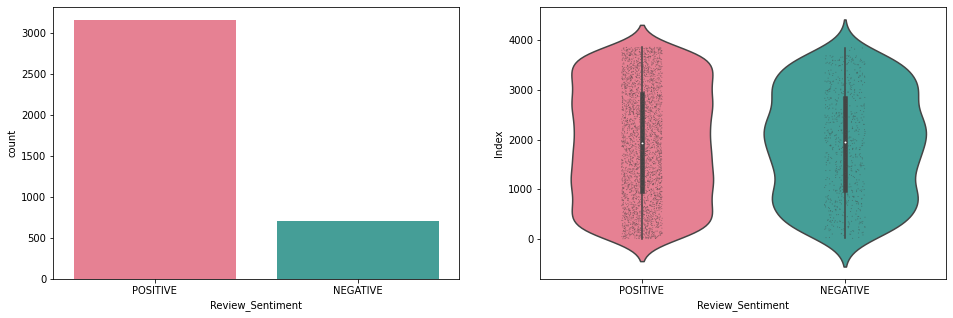

In [ ]:
%%time
#Sentiment classes count
df_class=df['Review_Sentiment'].value_counts()
print('Count of Sentiment classes :\n',df_class)
#Percentage of Sentiment classes count
per_revenue_class=df['Review_Sentiment'].value_counts()/len(df)*100
print('percentage of count of Sentiment classes :\n',per_revenue_class)

#Countplot and violin plot for Sentiment classes
fig,ax=plt.subplots(1,2,figsize=(16,5))
sns.countplot(df.Review_Sentiment.values,ax=ax[0],palette='husl')
sns.violinplot(x=df.Review_Sentiment.values,y=df.index.values,ax=ax[1],palette='husl')
sns.stripplot(x=df.Review_Sentiment.values,y=df.index.values,jitter=True,color='black',linewidth=0.5,size=0.5,alpha=0.5,ax=ax[1],palette='husl')
ax[0].set_xlabel('Review_Sentiment')
ax[1].set_xlabel('Review_Sentiment')
ax[1].set_ylabel('Index')

**Take aways:**                   
* We have imbalanced data, where 81.8% of the data represents the positive class and 18.18% of the data represents the Negative class.
* If you look at the jitter in violin plot, we can say that Sentiment classes distributed  uniformly over the indexs of the dataframe and Also we can observe the imbalanced class distribution where the Positive class is most densely distributed than the Negative class.

In [ ]:
# General stats about Review_Sentiment feature
sa_df.describe()

,Review,review_preprocessed,Review_Sentiment,Restaurant_Name
count,3861,3861,3861,3861
unique,3846,3846,2,439
top,[b'10/10 for the food I recommend this restaur...,great restaurant great arabic food staff frien...,POSITIVE,Cafe Bagatalle
freq,2,2,3159,10


Split the dataset into train & test sets

We will split dataset into train data (80 %) and test data (20 %)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['review_preprocessed'],df.Review_Sentiment, test_size=0.2, random_state = 42)

In [ ]:
print('Dataset shapes')
print('X_train : {}'.format(X_train.shape))
print('X_test : {}'.format(X_test.shape))
print('y_train : {}'.format(y_train.shape))
print('y_test : {}'.format(y_test.shape))

Dataset shapes
X_train : (3088,)
X_test : (773,)
y_train : (3088,)
y_test : (773,)


Encode the Sentiment labels to 0 & 1

In [ ]:
#Encode using LabelBinarizer 0 -> Negative, 1-> Positive
lb=LabelBinarizer()
#Fit Review_Sentiment
encoder=lb.fit(y_train.values)

# Transform y_train, y_test
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
# Check y_train
y_train[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1]])

In [ ]:
# Check y_train
y_test[:10]

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### **Feature extraction from Text**

We are considering two approaches for extracting features from text for Sentiment analysis.
* Bag of Words
* TF-IDF

**Bag of Words**:
Bag of Words model is used to preprocess the text by converting it into a bag of words, which keeps a count of the total occurrences of most frequently used words.

**TF-IDF model** : 
TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique used to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

We are building 2 different SVM models for unbalanced class data & balanced data for these features.


### **Building SVM models for Unbalanced class data**

### **Bags of words model**

To convert text to numerical vectors, we are using Count vectorizer & TfidfTransformer for Bag of words model to extract features.


**Train SVM (Support vectot machine) model using Bag of words features**

In [ ]:
#training the support vector machine model
# Define a Pipeline
svm_bow = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel = 'linear',probability=True)),
               ])
# Initiate SVC
#fitting the svm for bag of words
svm_bow=svm_bow.fit(X_train,y_train)
print(svm_bow)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,

In [ ]:
#Accuracy of the model
BOW_svm_score=svm_bow.score(X_train,y_train)
print('Accuracy of the trained BOW SVM model :',round(BOW_svm_score,3))

Accuracy of the trained BOW SVM model : 0.975


**Model performance on test data**

In [ ]:
#SVM model prediction for bag of words
svm_bow_predict=svm_bow.predict(X_test)

#Test accuracy for bag of words 
svm_bow_score=accuracy_score(y_test,svm_bow_predict)

print("Test accuracy for SVM BoW model :", round(svm_bow_score,3))

Test accuracy for SVM BoW model : 0.89


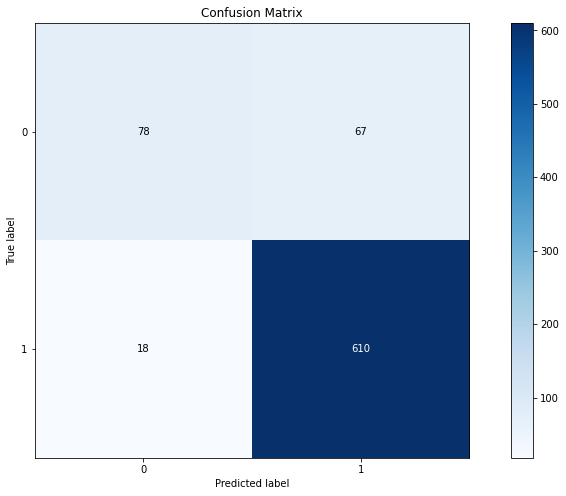

In [ ]:
#Confusion matrix
#Plot the confusion matrix
plot_confusion_matrix(y_test, svm_bow_predict, normalize=False,figsize=(15,8))

In [ ]:
# Classification report
class_report= classification_report(y_test, svm_bow_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.81      0.54      0.65       145
           1       0.90      0.97      0.93       628

    accuracy                           0.89       773
   macro avg       0.86      0.75      0.79       773
weighted avg       0.88      0.89      0.88       773



**Plot ROC (Receiver Operating Characteristic) curve**

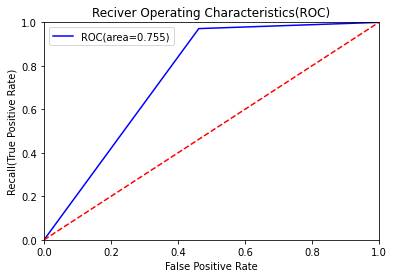

AUC: 0.7546343070502964


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test, svm_bow_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* AUC of 0.755 means the model is  making good guesses but not best. This is because the recall value for class 0 is low i.e., 0.54. So model is having difficulty in predicting class 0 correctly due to our training data has very low number of class 0 samples than class 1 , i.e., highly imbalanced data.

### **Term Frequency-Inverse Document Frequency (TFIDF) model**

It is used to convert text documents to matrix of tfidf features. We are considering TfidfVectorizer & TfidfTransformer for extracting tf-idf features.


**Train SVM (Support vectot machine) model using TF-IDF features**

In [ ]:
#training the support vector machine model
# Define a Pipeline
svm_tfidf = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel = 'linear', probability=True)),
               ])
#fitting the svm for bag of words
svm_tfidf=svm_tfidf.fit(X_train,y_train)
print(svm_tfidf)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_

In [ ]:
#Accuracy of the model
tfidf_svm_score=svm_tfidf.score(X_train,y_train)
print('Accuracy of the trained TF-IDF SVM model :',round(tfidf_svm_score,3))

Accuracy of the trained TF-IDF SVM model : 0.982


**Model performance on test data**

In [ ]:
##SVM model prediction using TF-IDF features
svm_tfidf_predict=svm_tfidf.predict(X_test)

#Test accuracy for bag of words 
svm_tfidf_score=accuracy_score(y_test,svm_tfidf_predict)

print("Test accuracy for SVM TF-IDF model :", round(svm_tfidf_score,3))

Test accuracy for SVM TF-IDF model : 0.89


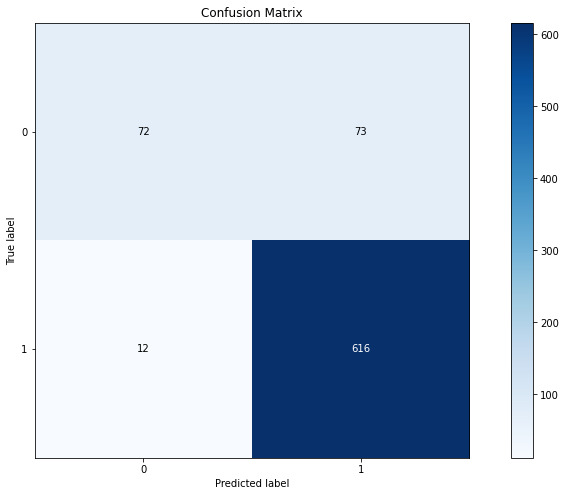

In [ ]:
#Confusion matrix
#Plot the confusion matrix
plot_confusion_matrix(y_test, svm_tfidf_predict, normalize=False,figsize=(15,8))

In [ ]:
# Classification report
class_report= classification_report(y_test, svm_tfidf_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.86      0.50      0.63       145
           1       0.89      0.98      0.94       628

    accuracy                           0.89       773
   macro avg       0.88      0.74      0.78       773
weighted avg       0.89      0.89      0.88       773



**Plot ROC (Receiver Operating Characteristic) curve**

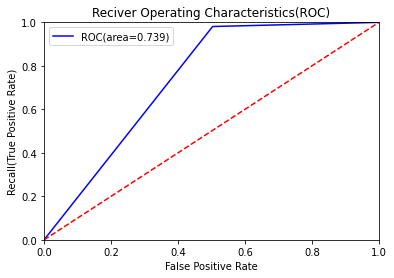

AUC: 0.7387217219415769


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test, svm_tfidf_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* AUC of 0.74 means the model is making good gueses. This  model also having difficulty in predicting class 0 correctly due to our training data has very low number of class 0 samples than class 1 , i.e., highly imbalanced data.

### **Building SVM models for balanced class data**

To balance classes in our dataset, we are assigning **class_weight='balanced'** in SVC algorithm.

**Bag of Words model**

**Train SVM (Support vectot machine) model using Bag of words features**

In [ ]:
#training the support vector machine model
svm_balanced_bow = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel='linear', probability=True, class_weight='balanced')),
               ])

#fitting the svm for bag of words
svm_bow=svm_balanced_bow.fit(X_train,y_train)
print(svm_bow)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_func

In [ ]:
#Accuracy of the model with SMOTE
BOW_svm_score=svm_balanced_bow.score(X_train,y_train)
print('Accuracy of the trained BOW SVM model for balanced class data :',round(BOW_svm_score,3))


Accuracy of the trained BOW SVM model for balanced class data : 0.982


**Model performance on test data**

In [ ]:
#SVM model prediction for bag of words
svm_bow_predict=svm_balanced_bow.predict(X_test)

#Test accuracy for bag of words 
svm_bow_score=accuracy_score(y_test,svm_bow_predict)

print("Test accuracy for SVM BoW model for balanced classes:", round(svm_bow_score,3))

Test accuracy for SVM BoW model for balanced classes: 0.886


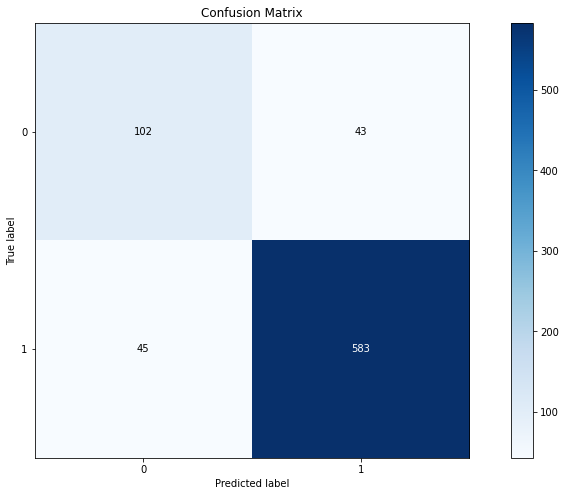

In [ ]:
#Confusion matrix
#Plot the confusion matrix
plot_confusion_matrix(y_test, svm_bow_predict, normalize=False,figsize=(15,8))

In [ ]:
# Classification report
class_report= classification_report(y_test, svm_bow_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.69      0.70      0.70       145
           1       0.93      0.93      0.93       628

    accuracy                           0.89       773
   macro avg       0.81      0.82      0.81       773
weighted avg       0.89      0.89      0.89       773



**Plot ROC curve**

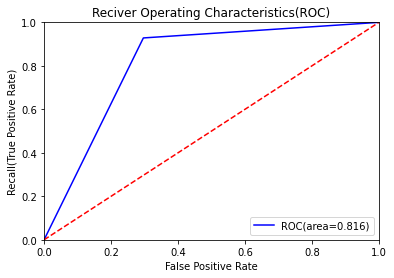

AUC: 0.8158961124533275


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test, svm_bow_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* Great, we can see 6.1 % improvement in model performance i.e., AUC from 0.755 to 0.815 after balancing the classes. This model is best among all models so far.

**TF-IDF model for balanced class data**

**Train SVM (Support vectot machine) model using TF-IDF features**

In [ ]:
#training the support vector machine model
#Define a Pipelne
svm_balanced_tfidf = Pipeline([('vect', TfidfVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel='linear', probability=True, class_weight='balanced')),
               ])

#fitting the svm for bag of words
svm_tfidf=svm_balanced_tfidf.fit(X_train, y_train)
print(svm_tfidf)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200,
      

In [ ]:
#Accuracy of the model
tfidf_svm_score=svm_balanced_tfidf.score(X_train,y_train)
print('Accuracy of the trained TF-IDF SVM model for balanced class data:',round(tfidf_svm_score,3))

Accuracy of the trained TF-IDF SVM model for balanced class data: 0.992


**Model performance on test data**

In [ ]:
##SVM model prediction using TF-IDF features
svm_tfidf_predict=svm_balanced_tfidf.predict(X_test)

#Test accuracy for bag of words 
svm_tfidf_score=accuracy_score(y_test,svm_tfidf_predict)

print("Test accuracy for SVM TF-IDF model for balanced class data:", round(svm_tfidf_score,3))

Test accuracy for SVM TF-IDF model for balanced class data: 0.891


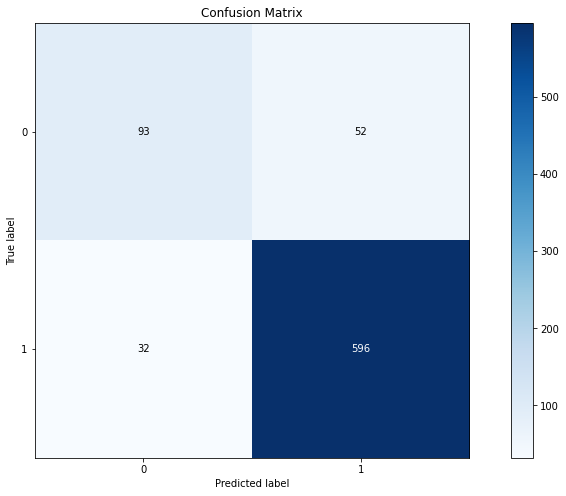

In [ ]:
#Plot the confusion matrix
plot_confusion_matrix(y_test, svm_tfidf_predict, normalize=False,figsize=(15,8))

In [ ]:
# Classification report
class_report= classification_report(y_test, svm_tfidf_predict)
print(class_report)

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       145
           1       0.92      0.95      0.93       628

    accuracy                           0.89       773
   macro avg       0.83      0.80      0.81       773
weighted avg       0.89      0.89      0.89       773



**Plot ROC curve**

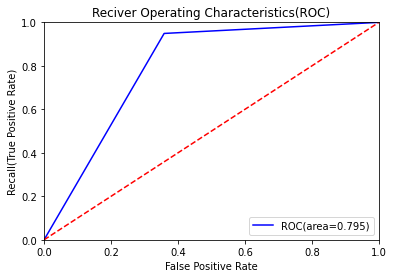

AUC: 0.7952119481660442


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=roc_curve(y_test, svm_tfidf_predict)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Insights:
* Good, we can see ~6 % improvement in TF-IDF model performance i.e., AUC changed from 0.738 to 0.795.

In [ ]:
Results={
    'Model':['BOW SVM model','TF-IDF SVM model'],
    'f1-score(balanced)':[0.89, 0.89],                # f1-score is weighted average
    'f1-score(unbalanced)':[0.88, 0.88],
    'AUC(balanced)':[0.815, 0.795],
    'AUC(unbalanced)':[0.755, 0.738]
}

results_df=pd.DataFrame(Results)
results_df

,Model,f1-score(balanced),f1-score(unbalanced),AUC(balanced),AUC(unbalanced)
0,BOW SVM model,0.89,0.88,0.815,0.755
1,TF-IDF SVM model,0.89,0.88,0.795,0.738


Insights:
* Among all models, BOW SVM model with balanced classes is the best with the AUC score of 0.815.
* 2nd best is TF-IDF SVM model with balanced classes with the AUC score of 0.795.

Hence, we will use **BOW SVM model with balanced classes** for final prediction & the **Ranking of Restaurants based on Sentiemnt score. Ranking of Restaurants will be done in RASA through custom function**.

In [ ]:
from joblib import dump, load

In [ ]:
# Pickle the BOW SVM model with balanced classes for prediction
filename = 'BOW_SVM_balanced_model.joblib'
dump(svm_balanced_bow, filename)

['BOW_SVM_balanced_model.joblib']

In [ ]:
# Load SVM balanced BOW model
svm_bow_model = load('BOW_SVM_balanced_model.joblib')

In [ ]:
df_final = sa_df.drop('Review',axis=1)
df_final.head()

,review_preprocessed,Review_Sentiment,Restaurant_Name
0,went lunch first part welcoming customer upto ...,POSITIVE,The Four Leafed Clover
1,great service delicious food lamb shank creamy...,POSITIVE,The Four Leafed Clover
2,went enough parking space staff friendly helpf...,POSITIVE,The Four Leafed Clover
3,good food ambience food ambience great definit...,POSITIVE,The Four Leafed Clover
4,excellent quiet clean place relaxed hangout fo...,POSITIVE,The Four Leafed Clover


In [ ]:
df_final.shape

(3861, 3)

In [ ]:
pred_sentiment_score = svm_bow_model.predict_proba(df_final['review_preprocessed'])

In [ ]:
pred_sentiment_score

array([[0.03030384, 0.96969616],
       [0.02928158, 0.97071842],
       [0.00745038, 0.99254962],
       ...,
       [0.0762414 , 0.9237586 ],
       [0.01141023, 0.98858977],
       [0.05129172, 0.94870828]])

In [ ]:
df_pred = pd.DataFrame(pred_sentiment_score, columns = ['Negative_score','Positive_score'])

In [ ]:
# Merge df_final & df_pred 
df_final = df_final.merge(df_pred, left_index=True, right_index=True)

In [ ]:
df_final

,review_preprocessed,Review_Sentiment,Restaurant_Name,Negative_score,Positive_score
0,went lunch first part welcoming customer upto ...,POSITIVE,The Four Leafed Clover,0.030304,0.969696
1,great service delicious food lamb shank creamy...,POSITIVE,The Four Leafed Clover,0.029282,0.970718
2,went enough parking space staff friendly helpf...,POSITIVE,The Four Leafed Clover,0.007450,0.992550
3,good food ambience food ambience great definit...,POSITIVE,The Four Leafed Clover,0.004229,0.995771
4,excellent quiet clean place relaxed hangout fo...,POSITIVE,The Four Leafed Clover,0.019740,0.980260
...,...,...,...,...,...
3856,nice experience nice foodhad anniversary cake ...,POSITIVE,Royal Thai - Cinnamon Lakeside,0.013002,0.986998
3857,visited royal thai restaurant cinnamon lakesid...,POSITIVE,Royal Thai - Cinnamon Lakeside,0.003927,0.996073
3858,due fact local restaurant closed corona virus ...,POSITIVE,Royal Thai - Cinnamon Lakeside,0.076241,0.923759
3859,ate 5320 whilst staying cinnamon lakeside food...,POSITIVE,Royal Thai - Cinnamon Lakeside,0.011410,0.988590


In [ ]:
df_final = df_final.drop(['review_preprocessed','Review_Sentiment'], axis=1)
df_group = df_final.groupby('Restaurant_Name').mean()

In [ ]:
df_group = df_group.sort_values(by = ['Positive_score'], ascending=False)

In [ ]:
df_group

,Negative_score,Positive_score
Restaurant_Name,,
Curry Leaf,0.000001,0.999999
Forty Seven Spice,0.001186,0.998814
Life's Good Kitchen,0.001731,0.998269
"The Ocean, The Kingsbury",0.001957,0.998043
Yue Chuan,0.002375,0.997625
...,...,...
Maharaja Palace,0.666558,0.333442
Majestic City,0.668580,0.331420
RE,0.673718,0.326282


In [ ]:
df_restaurant = df_group.reset_index(drop=False)

In [ ]:
df_restaurant

,Restaurant_Name,Negative_score,Positive_score
0,Curry Leaf,0.000001,0.999999
1,Forty Seven Spice,0.001186,0.998814
2,Life's Good Kitchen,0.001731,0.998269
3,"The Ocean, The Kingsbury",0.001957,0.998043
4,Yue Chuan,0.002375,0.997625
...,...,...,...
434,Maharaja Palace,0.666558,0.333442
435,Majestic City,0.668580,0.331420
436,RE,0.673718,0.326282
437,Jack Tree,0.687463,0.312537


In [ ]:
df_restaurant.to_csv('Restaurants_with_sentiment_scores.csv', index=False)